In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

In [2]:
NA = 6.022e23
t_MS = 1.0e17
# Linear evolution of temperature and density:
T0 = 1.3e7            # K at t = 0
T1 = 2.0e7            # K at t = t_MS
rho0 = 70.0           # g/cm^3 at t = 0
rho1 = 200.0          # g/cm^3 at t = t_MS

ne0 = 7.6e25          # cm^-3 (electron density at rho0)

def T_of_t_linear(t):
    """Linear evolution for temperature: T(t)=T0+(T1-T0)*(t/t_MS)"""
    return T0 + (T1 - T0) * (t / t_MS)

def rho_of_t_linear(t):
    """ Linear fit for Density over time """
    return rho0 + (rho1 - rho0)*(t / t_MS)

In [3]:
def CNO1_cycle(elements, elemChart,t9):
    """
    Construct the differential equations for systems of the CNO1 cycle.

    Parameters
    ----------
    elements : np.array
        Numpy array containing the number densities of the elements.
    elemChart : dict
        Dictionary containing the positions of the elements in the elements array.
    temp : float
        Temperature of the system in K.

    Returns
    -------
    dX : dict
        The differential equations for the system.
    """

    reaction_rates = {
        "C12(p,g)N13": (2.04e7/(t9**(2/3)) * np.exp(-13.690/(t9**(1/3)) - (t9/1.500)**2)),
        "C13(p,g)N14": (8.01e7/(t9**(2/3)) * np.exp(-13.717/(t9**(1/3)) - (t9/2)**2)),
        "N14(p,g)O15": (4.90e7/(t9**(2/3)) * np.exp(-15.228/(t9**(1/3)) - (t9/3.294)**2)),
        "N15(p,a)C12": (1.08e12/(t9**(2/3)) * np.exp(-15.251/(t9**(1/3)) - (t9/0.522)**2))
    }

    # Assume all the N13 decays immediately to C13 and all the O15 decays immediately to N15

    C12toC13 = reaction_rates["C12(p,g)N13"] * elements[elemChart["C12"]] * elements[elemChart["H1"]] / NA
    C13toN14 = reaction_rates["C13(p,g)N14"] * elements[elemChart["C13"]] * elements[elemChart["H1"]] / NA
    N14toN15 = reaction_rates["N14(p,g)O15"] * elements[elemChart["N14"]] * elements[elemChart["H1"]] / NA
    N15toC12 = reaction_rates["N15(p,a)C12"] * elements[elemChart["N15"]] * elements[elemChart["H1"]] / NA


    dX = {
        'H1': -C12toC13 - N15toC12 - C13toN14 - N14toN15,
        'He4': N15toC12,
        'C12': N15toC12 - C12toC13,
        'C13': C12toC13 - C13toN14,
        'N14': C13toN14 - N14toN15,
        'N15': N14toN15 - N15toC12
    }

    return dX

In [4]:
def CNO2_cycle(elements, elemChart, t9):
    """
    Construct the differential equations for systems of the CNO1 cycle.

    Parameters
    ----------
    elements : np.array
        Numpy array containing the number densities of the elements.
    elemChart : dict
        Dictionary containing the positions of the elements in the elements array.
    temp : float
        Temperature of the system in K.

    Returns
    -------
    dX : dict
        The differential equations for the system.
    """

    reaction_rates = {
        "N14(p,g)O15": (4.90e7/(t9**(2/3)) * np.exp(-15.228/(t9**(1/3)) - (t9/3.294)**2)),
        "N15(p,g)O16": (9.78e8/(t9**(2/3)) * np.exp(-15.251/(t9**(1/3)) - (t9/0.450)**2)),
        "O16(p,g)F17": (1.50e8/(t9**(2/3) * (1 + 2.13*(1 - np.exp(-0.728 * t9**(2/3))))) * np.exp(-16.692/(t9**(1/3)))),
        "O17(p,a)N14": (1.53e7/(t9**(2/3)) * np.exp(-16.712/(t9**(1/3)) - (t9/0.565)**2)),
    }

    # Assume all the O15 decays immediately to N15 and all the F17 decays immediately to O17

    N14toN15 = reaction_rates["N14(p,g)O15"] * elements[elemChart["N14"]] * elements[elemChart["H1"]] / NA
    N15toO16 = reaction_rates["N15(p,g)O16"] * elements[elemChart["N15"]] * elements[elemChart["H1"]] / NA
    O16toO17 = reaction_rates["O16(p,g)F17"] * elements[elemChart["O16"]] * elements[elemChart["H1"]] / NA
    O17toN14 = reaction_rates["O17(p,a)N14"] * elements[elemChart["O17"]] * elements[elemChart["H1"]] / NA

    dX = {
        "H1": -N14toN15 - N15toO16 - O16toO17 - O17toN14,
        "He4": O17toN14,
        "N14": O17toN14 - N14toN15,
        "N15": N14toN15 - N15toO16,
        "O16": N15toO16 - O16toO17,
        "O17": O16toO17 - O17toN14
    }

    return dX

In [5]:
def sigmav_pp(T9):
    return 4.01e-15 * T9**(-2/3) * np.exp(-3.380 * T9**(-1/3)) / NA

def sigmav_dp(T9):
    return 2.24e3 * T9**(-2/3) * np.exp(-3.720 * T9**(-1/3)) / NA

def sigmav_33(T9):
    return 6.04e10 * T9**(-2/3) * np.exp(-12.276 * T9**(-1/3)) / NA

def sigmav_34(T9):
    T9A = T9 / (1 + 4.95e-2 * T9)
    return 5.61e6 * (T9A**(5/6)) / (T9**(3/2)) * np.exp(-12.826 / (T9A**(1/3))) / NA

def sigmav_EC(T9):
    return 1.34e-10 * T9**(-1/2) / NA

def sigmav_li7p(T9):
    return 1.096e9 * T9**(-2/3) * np.exp(-8.472 * T9**(-1/3)) / NA

def sigmav_be7p(T9):
    return 3.11e5 * T9**(-2/3) * np.exp(-10.262 * T9**(-1/3)) / NA

# ⁸B decay constant
lambda_b8_decay = np.log(2) / 0.77


def PP_chain_cycle(elements, elemChart, T9):
    """
    Construct the differential equations for the pp-chain reaction network.

    Parameters
    ----------
    elements : np.array
        Array containing the number densities of the elements.
    elemChart : dict
        Dictionary mapping element names to positions in the elements array.
        Expected keys: 'H1', 'H2', 'He3', 'He4', 'Be7', 'Li7', 'B8'
    temp : float, optional
        Temperature of the system in K (default is 15e6 K).

    Returns
    -------
    dX : dict
        Dictionary containing the time derivatives of the element abundances,
        keyed by the element names.
    """

    # Extract current abundances (ensuring they are non-negative)
    H1  = max(elements[elemChart["H1"]], 0.0)
    H2  = max(elements[elemChart["H2"]], 0.0)
    He3 = max(elements[elemChart["He3"]], 0.0)
    He4 = max(elements[elemChart["He4"]], 0.0)
    Be7 = max(elements[elemChart["Be7"]], 0.0)
    Li7 = max(elements[elemChart["Li7"]], 0.0)
    B8  = max(elements[elemChart["B8"]], 0.0)

    # Assume a constant electron density
    ne = 7.6e25

    # Compute reaction rates using the provided functions
    r_pp   = H1 * H1 * sigmav_pp(T9)
    r_dp   = H2 * H1 * sigmav_dp(T9)
    r_33   = He3 * He3 * sigmav_33(T9)
    r_34   = He3 * He4 * sigmav_34(T9)
    r_EC   = Be7 * ne * sigmav_EC(T9)
    r_li7p = Li7 * H1 * sigmav_li7p(T9)
    r_be7p = Be7 * H1 * sigmav_be7p(T9)
    r_b8   = B8 * lambda_b8_decay

    # Construct differential equations for each species
    dH1_dt  = -2 * r_pp - r_dp - r_be7p - r_li7p + 2 * r_33
    dH2_dt  =  r_pp - r_dp
    dHe3_dt =  r_dp - 2 * r_33 - r_34
    dHe4_dt =  r_33 + 2 * r_li7p + 2 * r_b8 - r_34
    dBe7_dt =  r_34 - r_EC - r_be7p
    dLi7_dt =  r_EC - r_li7p
    dB8_dt  =  r_be7p - r_b8

    dX = {
        "H1":  dH1_dt,
        "H2":  dH2_dt,
        "He3": dHe3_dt,
        "He4": dHe4_dt,
        "Be7": dBe7_dt,
        "Li7": dLi7_dt,
        "B8":  dB8_dt
    }

    return dX

In [6]:
def triple_alpha(elements, elemChart, t9):

  reaction_rates = {
      "HeBe": ((7.40e-5 * t9**(-1.5) * np.exp(-1.0663 / t9)) + \
         4.164e9 * t9**(-2/3) * np.exp(-13.490 * t9 **(-1/3) - (t9 / 0.098)**2)),
      "BeHe": ((1.40e10 * t9 ** (3/2) * np.exp(1.0663 / t9))),
      "BeC": ((1.30e2 * t9 ** (-1.5) * np.exp(-3.3364 / t9)) + \
     2.510e7 * t9 ** (-2/3) * np.exp(-23.570 * t9 ** (-1/3) - (t9 / 0.235) ** 2))
    }

  He4_to_Be8 = reaction_rates["HeBe"] *  elements[elemChart["He4"]]**2 / NA
  Be8_to_He4 = reaction_rates["BeHe"] *  elements[elemChart["Be8"]] / NA
  Be8_to_C12 = reaction_rates["BeC"] * elements[elemChart["Be8"]] *  elements[elemChart["He4"]] / NA

  lambda_Be = np.log(2) / 8.19e-17


  dX = {
  "He4" : -2*He4_to_Be8 + 2 * Be8_to_He4 - Be8_to_C12 ,
  "Be8" : He4_to_Be8 - Be8_to_He4- Be8_to_C12 - lambda_Be * elements[elemChart["Be8"]],
  "C12" : Be8_to_C12
    }

  return dX

In [7]:
def C12toO16(elements, elemChart, temp):
    """
    Construct the differential equations for the C12 to O16 cycle.
    
    Parameters
    ----------
    elements : np.array
        Numpy array containing the number densities of the elements.
    elemChart : dict
        Dictionary containing the positions of the elements in the elements array.
    temp : float
        Temperature of the system in K.
    
    Returns
    -------
    dX : dict
        The differential equations for the system.
    """
    
    t9 = temp/1e9 # convert to 10^9 K
    
    forward_rate =  1.04e8 * (t9 ** 2) /( np.exp(1+0.0489 * (t9 ** 2/3)**2)) * np.exp(-32.120/(t9**(1/3)) - (t9/3.496)**2) + 1.76e8/(t9**2)
    
    C12toO16 = forward_rate * elements[elemChart["C12"]] * elements[elemChart["He4"]] / NA
    
    dX = {
        'C12': -C12toO16,
        'He4': -C12toO16,
        'O16': C12toO16
    }

    return dX

In [8]:
def diffEqs(t, elements, elemChart):
    """
    Construct the differential equations for the system.

    Parameters
    ----------
    t : float
        Time.
    elements : np.array
        Numpy array containing the number densities of the elements.
    elemChart : dict
        Dictionary containing the positions of the elements in the elements array.
    temp : float
        Temperature of the system in K.

    Returns
    -------
    dX : dict
        The differential equations for the system.
    """
    
    temp = T_of_t_linear(t)
    t9 = temp/1e9 # convert to 10^9 K
    rho_now = rho_of_t_linear(t)
    rho_factor = rho_now/rho0
    
    t9 = 15e6/1e9 # convert to 10^9 K
    
    dCNO1 = CNO1_cycle(elements, elemChart, t9)
    dCNO2 = CNO2_cycle(elements, elemChart, t9)
    dtriple_alpha = triple_alpha(elements, elemChart, t9)
    dpp_chain = PP_chain_cycle(elements, elemChart, t9)
    dC12O16 = C12toO16(elements, elemChart, temp)

    dX = np.zeros_like(elements)

    for key in dCNO1.keys():
        dX[elemChart[key]] = dCNO1[key]

    for key in dCNO2.keys():
        dX[elemChart[key]] = dCNO2[key]

    # for key in dtriple_alpha.keys():
    #     dX[elemChart[key]] = dtriple_alpha[key]

    for key in dpp_chain.keys():
        dX[elemChart[key]] = dpp_chain[key]
        
    # for key in dC12O16.keys():
    #     dX[elemChart[key]] = dC12O16[key]
    
    dX = dX * rho_factor**2

    return dX

In [9]:

# Look up table for the elements to make our lives easier
elemChart = {
    'H1': 0,
    'H2': 1,
    'He3': 2,
    'He4': 3,
    'Li7': 4,
    'Be7': 5,
    'Be8': 6,
    'B8': 7,
    'C12': 8,
    'C13': 9,
    'N14': 10,
    'N15': 11,
    'O16': 12,
    'O17': 13,
}

initialAbundances = np.zeros(len(elemChart))

H1_val = 1.0e25  # Normalized hydrogen number density

initialAbundances[elemChart['H1']] = H1_val
initialAbundances[elemChart['H2']] = H1_val * 2.0e-5         # Deuterium ~2e-5 of H1.
initialAbundances[elemChart['He3']] = H1_val * 1.0e-5        # Very low abundance.
initialAbundances[elemChart['He4']] = H1_val * 0.085         # Solar He/H ratio ~0.085.
initialAbundances[elemChart['Li7']] = H1_val * 1.0e-9        # Lithium is extremely rare.
initialAbundances[elemChart['Be7']] = H1_val * 1.0e-11       # Very scarce.
initialAbundances[elemChart['Be8']] = 0.0                    # 8Be is unstable.
initialAbundances[elemChart['B8']] = H1_val * 1.0e-12        # Boron is also very low.
# For the CNO elements, applying a ~50% depletion due to condensation:
initialAbundances[elemChart['C12']] = H1_val * 2.7e-4 * 0.5   # Solar C/H ~2.7e-4.
initialAbundances[elemChart['C13']] = H1_val * 3.0e-6 * 0.5   # C13 is much lower.
initialAbundances[elemChart['N14']] = H1_val * 6.8e-5 * 0.5   # Solar N/H ~6.8e-5.
initialAbundances[elemChart['N15']] = H1_val * 2.3e-7 * 0.5   # N15 is even lower.
initialAbundances[elemChart['O16']] = H1_val * 4.9e-4 * 0.5   # Solar O/H ~4.9e-4.
initialAbundances[elemChart['O17']] = H1_val * 1.9e-7 * 0.5   # O17 is very low.

In [10]:
t_start = 0.0
t_end   = 1e17

In [11]:
sols = solve_ivp(diffEqs, (t_start, t_end), initialAbundances, args=(elemChart,), method='BDF', rtol=1e-8, atol=1e-20)

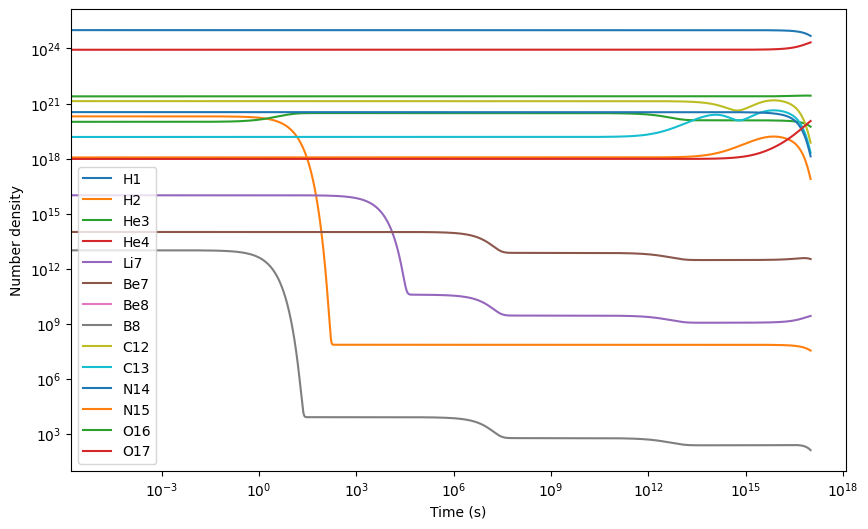

In [12]:
# Plot the results

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for key in elemChart.keys():
    ax.plot(sols.t, sols.y[elemChart[key]], label=key)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Number density')
ax.legend()
plt.show()

In [13]:
# Print final abundances
print("Final Abundances:")
for element, index in elemChart.items():
    print(f"{element}: {sols.y[index, -1]}")

Final Abundances:
H1: 4.8180232417824715e+24
H2: 34237158.35670144
He3: 5.46855707681767e+19
He4: 2.1456281930654944e+24
Li7: 2645127103.735449
Be7: 3328036678635.183
Be8: 0.0
B8: 128.38859092572602
C12: 7.322336384239629e+18
C13: 2.0831510530837064e+18
N14: 1.3311104257132782e+18
N15: 7.72917386710875e+16
O16: 2.679228150145514e+21
O17: 1.1146344769009734e+20
